## Notebook setup

In [310]:
%matplotlib inline

import os,sys,inspect
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

import shap
import autosklearn.metrics
import sklearn.metrics as sk_metrics
from sklearn.ensemble import RandomForestClassifier

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from model.model_util import *
from model.stats_util import *
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.utils import resample
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [340]:
# row has class condition: cols with accuracy, kappa, prec/recall
def build_clf_results(test_y, preds):
    
    results = np.zeros((len(preds),len(metric_columns)))
    
    for idx, pred in enumerate(preds):
        results[idx, 0] = sk_metrics.accuracy_score(test_y, pred)
        results[idx, 1] = sk_metrics.balanced_accuracy_score(test_y, pred)
        results[idx, 2] = sk_metrics.f1_score(test_y, pred, average='macro')
        results[idx, 3] = sk_metrics.f1_score(test_y, pred, average='micro')
        results[idx, 4] = sk_metrics.f1_score(test_y, pred, average='weighted')
        
    return results

metric_columns = ['accuracy', 'balanced accuracy', 'macro f1', 'micro f1', 'weighted f1']

def bootstrap_lowess(df, x_col, y_col, color, label, n_bootstraps=100, n_samples=100):

    x_min = df[x_col].min()
    x_max = df[x_col].max()
    sample_y = np.zeros((n_bootstraps, n_samples))
    sample_x = np.zeros((n_bootstraps, n_samples))


    for i in range(n_bootstraps):
        resampled_df = resample(df, n_samples=n_samples)
        x = resampled_df[x_col]
        y = resampled_df[y_col]

        filtered = lowess(y, x, return_sorted=True, it=3)
        sample_y[i, :] = filtered[:, 1]
        sample_x[i, :] = filtered[:, 0]

    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 97.5, axis=0), color=color, ls='--')
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 50, axis=0), color=color, label=label)
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 2.5, axis=0), color=color, ls='--')
    plt.legend()

In [32]:
# load data

# train features
top5_all_sb_train_data = pickle.load(open('../data/final_sandbox/top5_all_train_features.df', 'rb'))
top5_all_sb_test_data = pickle.load(open('../data/final_sandbox/top5_all_test_features.df', 'rb'))

age_qlabels = ["age_q" + str(x) for x in range(1,5)]
top5_all_data = pd.concat([top5_all_sb_train_data, top5_all_sb_test_data], axis=0)
top5_all_data['ego_age_q'], bins = pd.qcut(top5_all_data['ego_age'], q=4, labels=age_qlabels, retbins=True)

In [ ]:
# old data
# with open("../data/top5_final.df", "rb") as raw_file:
#     top_5_raw_df = pickle.load(raw_file)
    
# with open("../data/all_contacts_final.df", "rb") as raw_file:
#     all_raw_df = pickle.load(raw_file)

# with open('../data/demographics.df', 'rb') as demo_file:
#     demo_df = pickle.load(demo_file)
# demo_cols = ['pid', 'age', 'gender', 'education', 'employment', 'live_together', 'race', 'ethnicity', 'marital_status']

# Estimating Relationships and their Meaning from Phone Data: Paper statistics

## Survey data: contact type

|Question/measure label | Response range|
|-|-|
|contact_type |	{Significant Other, Friend, Family Member You Live With, Family Member You Don't Live With, Colleague/Work-Related, Task (e.g. Make an Appointment, Reservation, etc.), Other}|
|want_question |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)}|
|talk_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)}|
|loan_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)} |
|closeness |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)} |

In [5]:
print("{} total SMS".format(all_raw_df.loc[all_raw_df['comm_type'] == 'SMS'].shape[0]))

print("{} total calls".format(all_raw_df.loc[all_raw_df['comm_type'] == 'PHONE'].shape[0]))

print("All contact type counts")
all_raw_df.drop_duplicates('combined_hash').groupby('contact_type').count()[['comm_direction']]

337480 total SMS
49872 total calls
All contact type counts


,comm_direction
contact_type,
family_live_separate,1227
family_live_together,317
friend,1738
other,1925
sig_other,288
task,2231
work,1186


In [6]:
print("Contacts per participant")
all_raw_df.groupby("pid")['combined_hash'].nunique().describe()

Contacts per participant


count    200.000000
mean      44.560000
std       26.978614
min        1.000000
25%       25.000000
50%       37.500000
75%       58.000000
max      159.000000
Name: combined_hash, dtype: float64

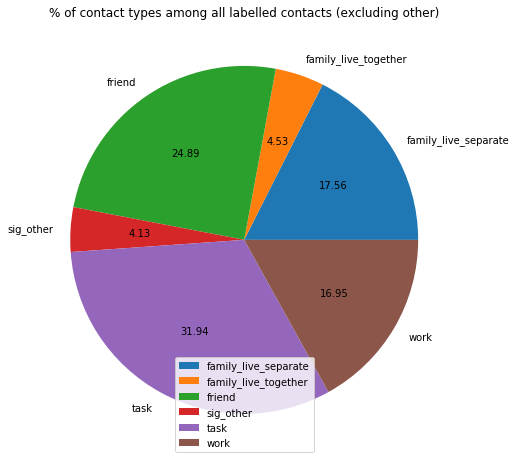

In [7]:
all_types = all_raw_df.loc[all_raw_df['contact_type'] != 'other']
all_types = all_types.drop_duplicates('combined_hash').groupby('contact_type').count()
all_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among all labelled contacts (excluding other)')
plt.legend(loc='lower center')
plt.ylabel("")
plt.show()

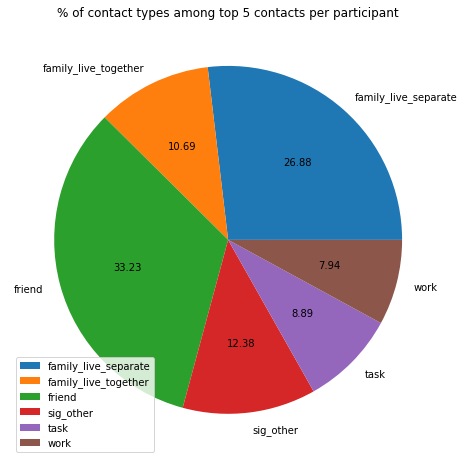

In [8]:
top_types = top_5_raw_df.drop_duplicates('combined_hash').groupby('contact_type').count()
top_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among top 5 contacts per participant')
plt.legend(loc='lower left')
plt.ylabel("")
plt.show()

In [9]:
top_count = 5
contact_counts = all_raw_df.groupby(['pid'])['combined_hash'].nunique()
drop_contacts = contact_counts.loc[(contact_counts < top_count)].index
coe_contact = all_raw_df.loc[~all_raw_df['pid'].isin(drop_contacts)]

coe_contact_top = all_raw_df.groupby(['pid', 'combined_hash']).count()
g = coe_contact_top['comm_direction'].groupby(level=0, group_keys=False)
top_hashes = g.nlargest(top_count).index.to_frame()['combined_hash'].values
top_contacts = all_raw_df.loc[all_raw_df['combined_hash'].isin(top_hashes)]

In [10]:
#top_contacts.drop_duplicates('combined_hash').groupby('contact_type').count()

In [11]:
print("Top five contact type counts")
display(top_types[['comm_type']])

Top five contact type counts


,comm_type
contact_type,
family_live_separate,254
family_live_together,101
friend,314
sig_other,117
task,84
work,75


## Results: Six-class relationship prediction

In [12]:
metric_columns = ['accuracy', 'balanced accuracy', 'macro f1', 'weighted f1']


# row has class condition: cols with accuracy, kappa, prec/recall
def build_clf_results(test_y, preds):
    
    results = np.zeros((len(preds),len(metric_columns)))
    
    for idx, pred in enumerate(preds):
        results[idx, 0] = sk_metrics.accuracy_score(test_y, pred)
        results[idx, 1] = sk_metrics.balanced_accuracy_score(test_y, pred)
        results[idx, 2] = sk_metrics.f1_score(test_y, pred, average='macro')
        results[idx, 3] = sk_metrics.f1_score(test_y, pred, average='weighted')
        
    return results

# load default data
replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 3,
        "family_live_together": 4,
        "sig_other": 5
    }
}

contact_types = list(replace_dict['contact_type'].keys())

# load data
top_5_baseline_train = pickle.load(open('../data/rd2_features/top_5_baseline_train_features.df', 'rb'))
top_5_baseline_test =  pickle.load(open('../data/rd2_features/top_5_baseline_test_features.df', 'rb'))

train_data = top_5_baseline_train.replace(replace_dict)
test_data = top_5_baseline_test.replace(replace_dict)

train_y = train_data['contact_type']
train_X = train_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)
test_y = test_data['contact_type']
test_X = test_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)

features = ['baseline', 'age_gender', 'demo', 'all']
preds_6clf = []
idx_6clf = []

# add majority baseline
majority_baseline = [1] * len(test_y)
preds_6clf.append(majority_baseline)
idx_6clf.append("majority baseline")

# load predictions
for feat in features:
    with open("../model/rand_forest_top_5_{}_contact_type.predict".format(feat), 'rb') as pred_file:
        preds_6clf.append(pickle.load(pred_file))
        idx_6clf.append(feat + " RF")
        
for feat in features:
    with open("../model/final_results/top5/top5_{}_automl_6clf_final.predict".format(feat), 'rb') as pred_file:
        preds_6clf.append(pickle.load(pred_file))
        idx_6clf.append(feat + " AutoML")

In [13]:
metrics_6clf = build_clf_results(test_y, preds_6clf)
result_df = pd.DataFrame(metrics_6clf,index=idx_6clf, columns=metric_columns)
pd.options.display.float_format = '{:,.4f}'.format

display(result_df)
print(result_df.to_latex())

,accuracy,balanced accuracy,macro f1,weighted f1
majority baseline,0.3381,0.1667,0.0842,0.1709
baseline RF,0.4000,0.2994,0.2899,0.3559
age_gender RF,0.4476,0.3543,0.3627,0.4123
demo RF,0.4476,0.3330,0.3291,0.3905
all RF,0.4333,0.3733,0.3577,0.4106
baseline AutoML,0.4524,0.3617,0.3534,0.4113
age_gender AutoML,0.4619,0.4150,0.4294,0.4523
demo AutoML,0.4571,0.3818,0.3926,0.4344
all AutoML,0.4619,0.4178,0.4261,0.4517


\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  balanced accuracy &  macro f1 &  weighted f1 \\
\midrule
majority baseline &    0.3381 &             0.1667 &    0.0842 &       0.1709 \\
baseline RF       &    0.4000 &             0.2994 &    0.2899 &       0.3559 \\
age\_gender RF     &    0.4476 &             0.3543 &    0.3627 &       0.4123 \\
demo RF           &    0.4476 &             0.3330 &    0.3291 &       0.3905 \\
all RF            &    0.4333 &             0.3733 &    0.3577 &       0.4106 \\
baseline AutoML   &    0.4524 &             0.3617 &    0.3534 &       0.4113 \\
age\_gender AutoML &    0.4619 &             0.4150 &    0.4294 &       0.4523 \\
demo AutoML       &    0.4571 &             0.3818 &    0.3926 &       0.4344 \\
all AutoML        &    0.4619 &             0.4178 &    0.4261 &       0.4517 \\
\bottomrule
\end{tabular}



In [15]:
all_automl_6clf = pickle.load(open("../model/final_results/top5/top5_all_automl_6clf_final.automl", "rb"))
all_ensemble = all_automl_6clf.get_models_with_weights()
print_ensemble(all_ensemble)

[WARNING] [11:57:36:autosklearn.util.backend] Could not delete output dir: /tmp/autosklearn_output_25398_449
[WARNING] [11:57:36:autosklearn.util.backend] Could not delete tmp dir: /tmp/autosklearn_tmp_25398_449


Weight: 0.5800000000000001, classifier: adaboost
Weight: 0.08000000000000002, classifier: lda
Weight: 0.04000000000000001, classifier: gradient_boosting
Weight: 0.04000000000000001, classifier: multinomial_nb
Weight: 0.04000000000000001, classifier: xgradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: extra_trees
Weight: 0.020000000000000004, classifier: random_forest
Weight: 0.020000000000000004, classifier: lda
Weight: 0.020000000000000004, classifier: random_forest
Weight: 0.020000000000000004, classifier: adaboost


In [ ]:
types_abbrv = ['W', 'F', 'T', 'FLS', 'FLT', 'SO']
print(contact_types)
print(collections.Counter(test_y))
print(collections.Counter(automl_preds[-1]))

confuse_df = print_confusion_matrix(test_y, preds_6clf[-3], types_abbrv)

In [ ]:
print(confuse_df.to_latex())

## Results: Four-class relationship prediction

In [27]:
replace_dict_4clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 1,
        "task": 2,
        "family_live_together": 3,
        "sig_other": 3
    }
}


predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]


#train_data_4clf = top_5_baseline_train.replace(replace_dict_4clf)
#test_data_4clf = top_5_baseline_test.replace(replace_dict_4clf)

#test_y_4clf = test_data_4clf['contact_type']

# load the results
preds_4clf = []
idx_4clf = []
data_4clf = []

# majority prediction
majority_baseline = [1] * len(test_y_4clf)
preds_4clf.append(majority_baseline)
idx_4clf.append("majority baseline")
data_4clf.append("N/A")

features = ['baseline', 'age_gender', 'demo', 'all']

for feat in features:
    with open("../model/rd3_results/top_5_contact_type_{}_rf_short.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("Random forest")
        data_4clf.append(feat)

with open("../model/rd3_results/top_5_contact_type_all_long.predict", 'rb') as pred_file:
    preds_4clf.append(pickle.load(pred_file))
    idx_4clf.append("AutoML")
    data_4clf.append("all")       

with open("../model/rd3_results/top5_ag_only.predict", 'rb') as pred_file:
    preds_4clf.append(pickle.load(pred_file))
    idx_4clf.append("AutoML")
    data_4clf.append("age/gender only")           
    
for feat in features[:-1]:
    with open("../model/rd3_results/top_5_contact_type_{}.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("AutoML")
        data_4clf.append(feat)

with open("../model/rd3_results/top_5_contact_type_all_long.predict", 'rb') as pred_file:
    preds_4clf.append(pickle.load(pred_file))
    idx_4clf.append("AutoML")
    data_4clf.append("all")       

In [28]:
from collections import Counter
metrics_4clf = build_clf_results(test_y_4clf, preds_4clf)
results_4clf = pd.DataFrame(metrics_4clf, columns=metric_columns)

results_4clf = pd.concat([pd.Series(idx_4clf, name='model'),
                          pd.Series(data_4clf, name='features'),
                          results_4clf], axis=1)
pd.options.display.float_format = '{:,.4f}'.format

display(results_4clf)
print(results_4clf.to_latex(index=False))

,model,features,accuracy,balanced accuracy,macro f1,micro f1,weighted f1
0,majority baseline,N/A,0.5714,0.2500,0.1818,0.5714,0.4156
1,Random forest,baseline,0.6667,0.4590,0.4795,0.6667,0.6254
2,Random forest,age_gender,0.6667,0.4566,0.4750,0.6667,0.6225
3,Random forest,demo,0.6667,0.4369,0.4598,0.6667,0.6213
4,Random forest,all,0.6762,0.4546,0.4744,0.6762,0.6326
5,AutoML,all,0.7095,0.5221,0.5519,0.7095,0.6806
6,AutoML,age/gender only,0.5714,0.2500,0.1818,0.5714,0.4156
7,AutoML,baseline,0.6571,0.4598,0.4731,0.6571,0.6195
8,AutoML,age_gender,0.6905,0.5310,0.5488,0.6905,0.6654
9,AutoML,demo,0.7095,0.5344,0.5598,0.7095,0.6775


\begin{tabular}{llrrrrr}
\toprule
             model &         features &  accuracy &  balanced accuracy &  macro f1 &  micro f1 &  weighted f1 \\
\midrule
 majority baseline &              N/A &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
     Random forest &         baseline &    0.6667 &             0.4590 &    0.4795 &    0.6667 &       0.6254 \\
     Random forest &       age\_gender &    0.6667 &             0.4566 &    0.4750 &    0.6667 &       0.6225 \\
     Random forest &             demo &    0.6667 &             0.4369 &    0.4598 &    0.6667 &       0.6213 \\
     Random forest &              all &    0.6762 &             0.4546 &    0.4744 &    0.6762 &       0.6326 \\
            AutoML &              all &    0.7095 &             0.5221 &    0.5519 &    0.7095 &       0.6806 \\
            AutoML &  age/gender only &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
            AutoML &         baseline &    0.6571 & 

## Feature correlations

## Feature importance

### Age/gender model

In [ ]:
# Load data and models
ag_predict_proba = pickle.load(open("../model/feature_importance/age_gender.predict_proba", "rb"))
ag_shap_vals = pickle.load(open("../model/feature_importance/age_gender.shap_values", "rb"))

predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

age_gender_train_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_test_features.df', 'rb'))

age_gender_train_data = age_gender_train_data.replace(replace_dict)
age_gender_test_data = age_gender_test_data.replace(replace_dict)

age_gender_train_y = age_gender_train_data['contact_type']
age_gender_train_X = age_gender_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_test_y = age_gender_test_data['contact_type']
age_gender_test_X = age_gender_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')


In [ ]:
shap.initjs()

In [ ]:
age_gender_explainer = shap.KernelExplainer(ag_predict_proba, shap.kmeans(age_gender_train_X, 10), link="logit")

In [ ]:
shap.force_plot(age_gender_explainer.expected_value[0], ag_shap_vals[0], age_gender_test_X, link="logit")

In [ ]:
feature_names = age_gender_test_X.columns.values
feature_dict = {
    'total_comm_days': 'total # communication days',
    'time_of_day_5_sms': '8pm - 12am texts',
    'time_of_day_3_calls': '12pm - 4pm calls',
    'time_of_day_4_calls': '4pm - 8pm calls',
    'time_of_day_2_calls': '8am - 12pm calls',
    'time_of_day_5_calls': '8pm - 12am calls',
    'day_6_sms': 'Sunday texts',
    'total_comms': 'total # communications',
    'time_of_day_4_sms': '4pm - 8pm texts',
    'avg_in_duration_nan_indicator': 'call feature missing indicator',
    'time_of_day_2_sms': '8am - 12pm texts',
    'day_0_sms': 'Monday texts',
    'time_of_day_0_sms': '12am - 4am texts',
    'time_of_day_1_sms': '4am - 8am texts',
    'total_sms': 'total # texts',
    'total_call_days': 'total # call days',
    'avg_in_duration': 'mean incoming call duration',
    'day_1_sms': 'Tuesday texts', 
    'day_3_sms': 'Thursday texts',
    'day_5_calls': 'Saturday calls',
}

feature_names = list(map(lambda x: feature_dict[x] if x in feature_dict else x, feature_names))

In [ ]:
font = {
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [8,8]
plt.rcParams.update({'figure.autolayout': True})

contact_types = ["work", "social separate", "task", "family together"]
shap.summary_plot(ag_shap_vals, age_gender_test_X, plot_type='dots', show=False, class_names=contact_types, feature_names=feature_names, max_display=20)
#plt.title("Top 20 features by SHAP contribution")

#plt.ylabel("features")
#plt.tight_layout()

plt.savefig("../tex/figures/top5_ag_shap_no_title.png", dpi=300, bbox_inches='tight')

### All features model

In [ ]:
# Load data and models
all_predict_proba = pickle.load(open("../model/feature_importance/all.predict_proba", "rb"))
all_shap_vals = pickle.load(open("../model/feature_importance/all.shap_values", "rb"))

predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

all_train_data = pickle.load(open('../data/final_features_jan28/top_5_all_train_features.df', 'rb'))
all_test_data = pickle.load(open('../data/final_features_jan28/top_5_all_test_features.df', 'rb'))

all_train_data = all_train_data.replace(replace_dict)
all_test_data = all_test_data.replace(replace_dict)

all_train_y = all_train_data['contact_type']
all_train_X = all_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
all_test_y = all_test_data['contact_type']
all_test_X = all_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')


In [ ]:
all_feature_dict = {
    'total_comm_days': 'total # communication days',
    'avg_in_duration': 'mean incoming call duration',
    'mean_in_call': 'mean incoming call frequency',

    'time_of_day_0_sms': '12am - 4am texts',
    'total_comms': 'total # communications',  
    'call_visit_reason:errand': 'calls at \"errand\" locations',
    'time_of_day_5_sms': '8pm - 12am texts',
    'reg_comm': 'communication regularity',
    'avg_out_duration': 'mean outgoing call duration',
    'day_0_sms': 'Monday texts',

    'time_of_day_3_calls': '12pm - 4pm calls',
    'time_of_day_4_calls': '4pm - 8pm calls',
    'time_of_day_2_calls': '8am - 12pm calls',
    'day_6_sms': 'Sunday texts',
    'time_of_day_2_sms': '8am - 12pm texts',
    'time_of_day_1_sms': '4am - 8am texts',
    'missed_in_calls': 'missed to incoming call ratio',
    'reg_sms': 'texting regularity',
    'call_loc:shop': 'calls at \"shop\" locations',
}

import matplotlib.pyplot as plt

all_feature_names = all_test_X.columns.values

all_feature_names = list(map(lambda x: all_feature_dict[x] if x in all_feature_dict else x, all_feature_names))

all_explainer = shap.KernelExplainer(all_predict_proba, shap.kmeans(all_train_X, 10), link="logit")

font = {
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
#plt.rcParams.update({'figure.autolayout': False})
plt.rcParams["figure.figsize"] = [8, 8]

contact_types = ["work", "social separate", "task", "family together"]
shap.summary_plot(all_shap_vals, all_test_X, plot_type='dots', show=False, class_names=contact_types, feature_names=all_feature_names, max_display=15)
#plt.title("Top 20 features by SHAP contribution")

#plt.ylabel("features")
plt.tight_layout()

plt.savefig("../tex/figures/top5_all_shap_no_title.png", dpi=300, bbox_inches='tight')

## Revision Statistics

#### Details on the number of participants

In [47]:
all_contacts_final = pd.read_pickle("/data2/tliu/relationship-prediction/data/all_contacts_final.df")

In [48]:
all_contacts_unique = all_contacts_final.drop_duplicates(subset='contact_number')
print(all_contacts_unique.shape)
all_contacts_unique = all_contacts_unique.loc[all_contacts_unique['contact_type'] != 'other']

(8771, 42)


In [26]:
all_contacts_unique['pid'].value_counts()

1255682    117
1179075    112
TP903SN    112
25349      101
IK750RN     86
1080326     85
1565499     83
1143410     82
1126438     81
1170978     80
1272711     79
639010      79
1531633     76
1382086     76
1307868     75
WT253RB     75
1079411     75
1078563     73
1219403     72
1564420     71
827285      71
FJ227MJ     68
1013558     68
HH880DL     68
820387      66
1184498     60
1128660     60
XF600QF     60
1567871     60
QG620BT     59
          ... 
920558      14
1409046     14
1533327     14
HE593LT     14
1428949     14
1305690     14
1524947     13
1495049     13
1213535     12
1230637     12
1288818     10
391378      10
62977       10
1433908     10
1557966      9
1054952      9
555220       9
1578395      8
1549226      8
1183252      8
1374066      7
1155329      7
1403756      6
1157796      6
1495360      6
831987       5
872451       5
1328568      5
733021       2
1041667      1
Name: pid, Length: 199, dtype: int64

In [46]:
all_contacts_unique.shape

(7200, 42)

#### Participant demographics

In [162]:
demo_df = pd.read_pickle("/data2/tliu/relationship-prediction/data/demographics.df")
top5_final = pd.read_pickle("/data2/tliu/relationship-prediction/data/top5_final.df")

In [163]:
pids = top5_final['pid'].unique()

In [164]:
demo_df = demo_df.loc[demo_df['pid'].isin(pids)]

In [165]:
demo_df['employment'].value_counts()

employed      119
unemployed     36
disability     16
other          14
retired         4
Name: employment, dtype: int64

### Contact Frequency vs Social Support

In [166]:
emc_to_canonical = pickle.load(open("/data2/tliu/relationship-prediction/data/emc_to_canonical.dict", "rb"))
pr_dict = pickle.load(open("/data2/tliu/relationship-prediction/data/pr.dict", "rb"))
emc_all = pd.read_pickle("/data2/tliu/relationship-prediction/data/emc_all.df")

In [167]:
emc_all['q_total'] = emc_all['q1_want'] + emc_all['q2_talk'] + emc_all['q3_loan'] + emc_all['q4_closeness']
emc_all['q_total'].isna().sum()

In [182]:
# build md5 to q_total dict
q_total_dict = {}
emc_all = emc_all.reset_index(drop=True)
for i in range(emc_all.shape[0]):
    hash_name = emc_all.loc[i, 'contact_name']
    if hash_name in emc_to_canonical:
        canonical_md5 = emc_to_canonical[hash_name]
        if len(canonical_md5) > 0 and canonical_md5[0] in pr_dict:
            non_canonical_hashes = pr_dict[canonical_md5[0]]
            for h in non_canonical_hashes:
                q_total_dict[h] = emc_all.loc[i, 'q_total']

In [244]:
all_contacts_final['combined_hash'] = all_contacts_final['pid'] + all_contacts_final['canonical_hash']

In [245]:
all_contacts_final['combined_hash'].unique().shape

(8912,)

In [249]:
all_contacts_final['contact_number'].unique().shape

(8771,)

In [276]:
top5_train.loc[top5_train['pid'] == '1444502']

,pid,combined_hash,total_comms,total_comm_days,contact_type,total_calls,total_sms,total_sms_days,total_call_days,reg_call,...,std_out_sms_nan_indicator,missed_in_calls_nan_indicator,missed_out_calls_nan_indicator,in_out_sms_nan_indicator,avg_in_duration_nan_indicator,avg_out_duration_nan_indicator,q1_want,q2_talk,q3_loan,q4_closeness
415,1444502,14445020b7150f0859f59a572325ceb08d131cd,232,15,family_live_together,1.0,231.0,14.0,1.0,0.012987,...,0,1,0,0,1,0,0.600000,3.0,4.0,1.0
416,1444502,14445020ca8c3e6eaaee4adf1d5e88b20c74fc8,27296,75,task,55.0,27241.0,75.0,16.0,0.207792,...,0,0,0,0,0,0,0.000000,0.0,0.0,0.0
417,1444502,1444502737a730a1141dcfb423b61a219dadc44,577,47,family_live_separate,8.0,569.0,47.0,6.0,0.077922,...,0,1,1,0,1,1,5.933333,6.0,6.0,6.0
418,1444502,14445029953f68025a3c81b179791ae8541eb9c,262,18,family_live_separate,0.0,262.0,18.0,0.0,0.000000,...,0,1,1,0,1,1,5.933333,6.0,6.0,6.0
419,1444502,1444502de667e6dfdc578875f1876e7f5664592,556,44,family_live_separate,0.0,556.0,44.0,0.0,0.000000,...,0,1,1,0,1,1,6.000000,5.0,2.0,4.0


In [270]:
comm_counts = all_contacts_final.groupby(['pid'])['canonical_hash'].value_counts().to_frame()
comm_counts.columns = ['comm_counts']
comm_counts = comm_counts.reset_index()
#comm_counts['rank'] = comm_counts.groupby(['pid'], as_index=False).cumcount()
comm_counts['rank'] = comm_counts.groupby(['pid'], as_index=False)['comm_counts'].rank("dense", ascending=False)

In [271]:
comm_counts.shape

(8912, 4)

In [277]:
# TODO map canonical hash to the q_total amount

In [272]:
comm_counts.head()

,pid,canonical_hash,comm_counts,rank
0,1002060,b07d836f246e50ce930bf90a9fe33939,199,1.0
1,1002060,37bc00d68a24a359c7e5c7fc0c7bf7b8,121,2.0
2,1002060,7fbbe92349588238af4c0417afa1d6d0,83,3.0
3,1002060,4dee72583ac5647caf9d876b53ca158c,75,4.0
4,1002060,632572ef12203e84583c0cab0295337f,50,5.0


In [256]:
comm_counts.loc[comm_counts['canonical_hash'] == '0ca8c3e6eaaee4adf1d5e88b20c74fc8']

,pid,canonical_hash,comm_counts,rank
123,1027472,0ca8c3e6eaaee4adf1d5e88b20c74fc8,94,5.0
3627,1328707,0ca8c3e6eaaee4adf1d5e88b20c74fc8,15,8.0
4210,1444502,0ca8c3e6eaaee4adf1d5e88b20c74fc8,27296,1.0
4451,1503395,0ca8c3e6eaaee4adf1d5e88b20c74fc8,7,17.0
4467,1505268,0ca8c3e6eaaee4adf1d5e88b20c74fc8,240,2.0
4830,1550259,0ca8c3e6eaaee4adf1d5e88b20c74fc8,1152,1.0
6204,616751,0ca8c3e6eaaee4adf1d5e88b20c74fc8,136,6.0
6511,662410,0ca8c3e6eaaee4adf1d5e88b20c74fc8,137,3.0


In [213]:
top5_train = pd.read_pickle("../data/final_sandbox/top5_baseline_train_features.df")

In [214]:
top5_train.head()

,pid,combined_hash,total_comms,total_comm_days,contact_type,total_calls,total_sms,total_sms_days,total_call_days,reg_call,...,std_out_sms_nan_indicator,missed_in_calls_nan_indicator,missed_out_calls_nan_indicator,in_out_sms_nan_indicator,avg_in_duration_nan_indicator,avg_out_duration_nan_indicator,q1_want,q2_talk,q3_loan,q4_closeness
0,1002060,100206037bc00d68a24a359c7e5c7fc0c7bf7b8,121,23,family_live_separate,46.0,75.0,17.0,19.0,0.327586,...,0,0,0,0,0,0,5.600000,5.000,6.0,5.0
1,1002060,10020604dee72583ac5647caf9d876b53ca158c,75,10,family_live_separate,7.0,68.0,10.0,3.0,0.051724,...,0,0,0,0,0,0,6.000000,5.875,0.0,6.0
2,1002060,1002060632572ef12203e84583c0cab0295337f,50,5,friend,2.0,48.0,5.0,1.0,0.017241,...,0,1,0,0,1,0,3.200000,2.000,0.0,0.0
3,1002060,10020607fbbe92349588238af4c0417afa1d6d0,83,17,family_live_separate,15.0,68.0,9.0,11.0,0.189655,...,0,0,0,0,0,0,5.714286,6.000,6.0,6.0
4,1002060,1002060b07d836f246e50ce930bf90a9fe33939,199,36,sig_other,108.0,91.0,17.0,34.0,0.586207,...,0,0,0,0,0,0,6.000000,5.000,6.0,6.0


In [278]:
all_train = pd.read_pickle("/data2/tliu/relationship-prediction/data/y50_data/final_features/all_contacts_baseline_train_features.df")
all_test = pd.read_pickle("/data2/tliu/relationship-prediction/data/y50_data/final_features/all_contacts_baseline_test_features.df")

In [279]:
all_df = all_train.append(all_test)

In [280]:
all_df.shape

(6998, 282)

In [290]:
all_df['q_total'] = all_df['q1_want'] + all_df['q2_talk'] + all_df['q3_loan'] + all_df['q4_closeness']
all_df['rank'] = all_df.groupby(['pid'], as_index=False)['total_comms'].rank("dense", ascending=False)

(0, 30)

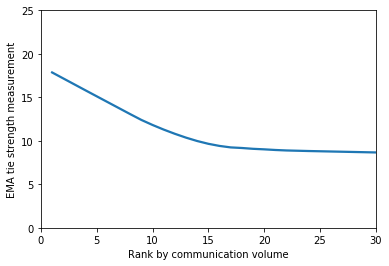

In [297]:
sns.regplot(x='rank', y='q_total', lowess=True, scatter=False, data=all_df)
plt.xlabel("Rank by communication volume")
plt.ylabel("EMA tie strength measurement")
plt.ylim(0,25)
plt.xlim(0,30)

In [352]:
from skmisc.loess import loess

pair = zip(all_df['rank'], all_df['q_total'])
sorted_pair = sorted(list(pair), key=lambda x: x[0])

In [354]:
x = [tup[0] for tup in sorted_pair]
y = [tup[1] for tup in sorted_pair]

In [355]:
l = loess(x, y)
l.fit()
pred = l.predict(x, stderror=True)
conf = pred.confidence()
lowess = pred.values
ll = conf.lower
ul = conf.upper

In [388]:
all_df['contact_type'].value_counts()

task                    2235
friend                  1742
family_live_separate    1229
work                    1186
family_live_together     317
sig_other                289
Name: contact_type, dtype: int64

In [389]:
1232 + 317 + 1742 + 1939 + 289 + 2240 + 1189

8948

In [390]:
emc_all.shape

(9890, 8)

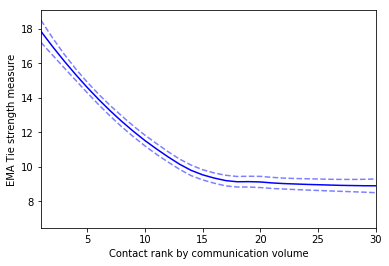

In [387]:
plt.plot(x, lowess, color='blue')
plt.plot(x, ll, ls='--', color='blue', alpha=0.5)
plt.plot(x, ul, ls='--', color='blue', alpha=0.5)

#plt.fill_between(x, ll, ul, facecolor='grey', alpha=0.3, label='95% CI')
plt.xlim(1,30)
#plt.legend()
plt.ylabel("EMA Tie strength measure")
plt.xlabel("Contact rank by communication volume")
#plt.title("The relationship between communication volume and tie strength")
plt.savefig("../tex/figures/tie_str_rank.pdf", dpi=300, bbox_inches='tight')

In [376]:
from scipy.stats import spearmanr

spearmanr(all_df['rank'], all_df['q_total'])

SpearmanrResult(correlation=-0.29376241033857237, pvalue=2.558534020413513e-139)

#### Top 5 contacts comparison

In [147]:
top5_final = pd.read_pickle("/data2/tliu/relationship-prediction/data/top5_final.df")

In [188]:
top5_final['q_total'] = top5_final['contact_number'].map(q_total_dict)

## Sandbox: out of sample test set results

In [12]:
replace_dict_4clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 1,
        "task": 2,
        "family_live_together": 3,
        "sig_other": 3
    }
}


predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

with open("../data/age_features/top5_comm_train_features.df", "rb") as train_f:
    train_data_4clf = pickle.load(train_f)
with open("../data/age_features/top5_comm_test_features.df", "rb") as test_f:
    test_data_4clf = pickle.load(test_f)

train_data_4clf = train_data_4clf.replace(replace_dict_4clf)
test_data_4clf = test_data_4clf.replace(replace_dict_4clf)
test_y_4clf = test_data_4clf['contact_type']

age_features = ['age', 'comm', 'age_comm', 'all']

In [19]:
# load the results
preds_4clf = []
idx_4clf = []
data_4clf = []

# majority prediction
majority_baseline = [1] * len(test_y_4clf)
preds_4clf.append(majority_baseline)
idx_4clf.append("majority baseline")
data_4clf.append("N/A")

# TODO random forest runs
# for feat in age_features:
#     with open("../model/rd3_results/top_5_contact_type_{}_rf_short.predict".format(feat), 'rb') as pred_file:
#         preds_4clf.append(pickle.load(pred_file))
#         idx_4clf.append("Random forest")
#         data_4clf.append(feat)

for feat in age_features:
    with open("../model/age_results/{}_automl.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("AutoML weighted")
        data_4clf.append(feat)
        
for feat in age_features:
    with open("../model/age_results/{}_automl_macro.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("AutoML macro")
        data_4clf.append(feat)

In [20]:
metrics_4clf = build_clf_results(test_y_4clf, preds_4clf)
results_4clf = pd.DataFrame(metrics_4clf, columns=metric_columns)

results_4clf = pd.concat([pd.Series(idx_4clf, name='model'),
                          pd.Series(data_4clf, name='features'),
                          results_4clf], axis=1)
pd.options.display.float_format = '{:,.4f}'.format

display(results_4clf)
print(results_4clf.to_latex(index=False))

,model,features,accuracy,balanced accuracy,macro f1,micro f1,weighted f1
0,majority baseline,N/A,0.5714,0.2500,0.1818,0.5714,0.4156
1,AutoML weighted,age,0.5714,0.2500,0.1818,0.5714,0.4156
2,AutoML weighted,comm,0.6524,0.5328,0.5404,0.6524,0.6433
3,AutoML weighted,age_comm,0.6810,0.5268,0.5388,0.6810,0.6592
4,AutoML weighted,all,0.6952,0.5183,0.5358,0.6952,0.6699
5,AutoML macro,age,0.4000,0.3301,0.3167,0.4000,0.4181
6,AutoML macro,comm,0.6667,0.5710,0.5701,0.6667,0.6620
7,AutoML macro,age_comm,0.6762,0.5481,0.5423,0.6762,0.6612
8,AutoML macro,all,0.6762,0.5580,0.5407,0.6762,0.6630


\begin{tabular}{llrrrrr}
\toprule
             model &  features &  accuracy &  balanced accuracy &  macro f1 &  micro f1 &  weighted f1 \\
\midrule
 majority baseline &       N/A &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
   AutoML weighted &       age &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
   AutoML weighted &      comm &    0.6524 &             0.5328 &    0.5404 &    0.6524 &       0.6433 \\
   AutoML weighted &  age\_comm &    0.6810 &             0.5268 &    0.5388 &    0.6810 &       0.6592 \\
   AutoML weighted &       all &    0.6952 &             0.5183 &    0.5358 &    0.6952 &       0.6699 \\
      AutoML macro &       age &    0.4000 &             0.3301 &    0.3167 &    0.4000 &       0.4181 \\
      AutoML macro &      comm &    0.6667 &             0.5710 &    0.5701 &    0.6667 &       0.6620 \\
      AutoML macro &  age\_comm &    0.6762 &             0.5481 &    0.5423 &    0.6762 &       0.6612 \\
 